In [1]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install --upgrade segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.applications import VGG16
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

2024-12-10 02:25:24.204376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 02:25:24.204443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 02:25:24.206307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [3]:
# Mendafarkan path Dataset
dataset_path = '/kaggle/input/dataset-cmri-jantung/Dataset-CMRI-Jantung'
augment_type1 = 'rotating(40)'
dataset_path_augmented1 = f'{dataset_path}/augmentasi/{augment_type1}'
augment_type2 = 'flipping'
dataset_path_augmented2 = f'{dataset_path}/augmentasi/{augment_type2}'

In [4]:
# Mendaftarkan metode preprocessing menggunakan BACKBONE resnet34
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [5]:
# Mendaftarkan ukuran gambar
SIZE_X = 224
SIZE_Y = 224

In [6]:
# Mendaftarkan array train images dan train masks
train_images = []
train_masks = []

In [7]:
# Mendaftarkan 4 kelas warna masks
class_ranges = [
    ([226, 226, 226], [255, 255, 255]),  # Class 1 (white)
    ([151, 151, 151], [225, 225, 225]),  # Class 2 (light gray)
    ([50, 50, 50], [150, 150, 150]),     # Class 3 (darker gray)
    ([0, 0, 0], [49, 49, 49])            # Class 4 (black)
]

In [8]:
# Membuat fungsi load IMAGES dari suatu path
def load_images_from_path(base_path, subfolder_names, resize_dim):
    images = []
    for subfolder_name in subfolder_names:
        subfolder_path = os.path.join(base_path, "image", subfolder_name)
        for img_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, resize_dim)
            images.append(img)
    return images

# Membuat fungsi load MASKS dari suatu path
def load_masks_from_path(base_path, subfolder_names, class_ranges, resize_dim):
    masks = []
    for subfolder_name in subfolder_names:
        subfolder_path = os.path.join(base_path, "mask", subfolder_name)
        for mask_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            if mask is None:
                print(f"Failed to load mask from {mask_path}")
                continue
            mask = cv2.resize(mask, resize_dim)

            class_masks = []
            for (lower, upper) in class_ranges:
                mask_class = cv2.inRange(mask, np.array(lower), np.array(upper))
                mask_class = (mask_class / 255).astype(np.uint8)
                class_masks.append(mask_class)

            multiclass_mask = np.stack(class_masks, axis=-1)
            masks.append(multiclass_mask)
    return masks

In [9]:
# Melakukan load IMAGES dari path es_training dan ed_training
print("Loading original dataset images...")
original_train_images = load_images_from_path(dataset_path, ['es_training', 'ed_training'], (SIZE_X, SIZE_Y))
# Melakukan load MASKS dari path es_training_gt dan ed_training_gt
print("Loading original dataset masks...")
original_train_masks = load_masks_from_path(dataset_path, ['es_training_gt', 'ed_training_gt'], class_ranges, (SIZE_X, SIZE_Y))

Loading original dataset images...
Loading original dataset masks...


In [10]:
# Melakukan load IMAGES AUGMENTASI1 dari path es_training dan ed_training
print("Loading augmented dataset images...")
augmented_train_images1 = load_images_from_path(dataset_path_augmented1, ['es_training', 'ed_training'], (SIZE_X, SIZE_Y))
# Melakukan load MASKS AUGMENTASI1 dari path es_training_gt dan ed_training_gt
print("Loading augmented dataset masks...")
augmented_train_masks1 = load_masks_from_path(dataset_path_augmented1, ['es_training_gt', 'ed_training_gt'], class_ranges, (SIZE_X, SIZE_Y))

Loading augmented dataset images...
Loading augmented dataset masks...


In [11]:
# Melakukan load IMAGES AUGMENTASI2 dari path es_training dan ed_training
print("Loading augmented dataset images...")
augmented_train_images2 = load_images_from_path(dataset_path_augmented2, ['es_training', 'ed_training'], (SIZE_X, SIZE_Y))
# Melakukan load MASKS AUGMENTASI2 dari path es_training dan ed_training
print("Loading augmented dataset masks...")
augmented_train_masks2 = load_masks_from_path(dataset_path_augmented2, ['es_training_gt', 'ed_training_gt'], class_ranges, (SIZE_X, SIZE_Y))

Loading augmented dataset images...
Loading augmented dataset masks...


In [12]:
# Mengkombinasikan IMAGES Original, IMAGES Augmentasi 1, dan IMAGES Augmentasi 2
# Mengkombinasikan MASKS Original, MASKS Augmentasi 1, dan MASKS Augmentasi 2
print("Combining datasets...")
train_images = np.array(original_train_images + augmented_train_images1 + augmented_train_images2)
train_masks = np.array(original_train_masks + augmented_train_masks1 + augmented_train_masks2)

print(f'Train images shape: {train_images.shape}')
print(f'Train masks shape: {train_masks.shape}')

Combining datasets...
Train images shape: (3966, 224, 224, 3)
Train masks shape: (3966, 224, 224, 4)


In [13]:
# Melakukan Preprocess train images dan train masks
train_images = preprocess_input(train_images)
train_masks = preprocess_input(train_masks)

In [14]:
# Menngkonversikan masks ke float32
train_masks = train_masks.astype('float32')

print(f'Preprocessed train images shape: {train_images.shape}')
print(f'Preprocessed train masks shape: {train_masks.shape}')

Preprocessed train images shape: (3966, 224, 224, 3)
Preprocessed train masks shape: (3966, 224, 224, 4)


In [15]:
# Kode Arsitektur FCDenseNet
def single_dense_module(input_data):
    x = tf.keras.layers.BatchNormalization()(input_data)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    return x

def transition_down(input_data):
    input_channel = int(input_data.shape[3])
    x = tf.keras.layers.BatchNormalization()(input_data)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(input_channel, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    return x

def transition_up(skip_connection, upsample_block, filter_no):
    x = tf.keras.layers.Concatenate(axis=3)(upsample_block)
    x = tf.keras.layers.Conv2DTranspose(filter_no, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.Concatenate(axis=3)([x, skip_connection])
    return x

def FCDenseNet(n_classes, input_height, input_width):
    input_images = Input(shape=(input_height, input_width, 3))

    x = tf.keras.layers.BatchNormalization()(input_images)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=True)(x)

    skip_connection = []
    #down block 1
    for i in range(4):
        output = single_dense_module(x)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])
    skip_connection.append(x)
    x = transition_down(x)

    #down block 2
    for i in range(5):
        output = single_dense_module(x)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])
    skip_connection.append(x)
    x = transition_down(x)

    #down block 3
    for i in range(7):
        output = single_dense_module(x)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])
    skip_connection.append(x)
    x = transition_down(x)

    #down block 4
    for i in range(10):
        output = single_dense_module(x)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])
    skip_connection.append(x)
    x = transition_down(x)

    #down block 5
    for i in range(12):
        output = single_dense_module(x)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])
    skip_connection.append(x)
    x = transition_down(x)

    #bottleneck block
    upsample_block = []
    for i in range(15):
        output = single_dense_module(x)
        upsample_block.append(output)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])

    #up block 1
    x = transition_up(skip_connection[4], upsample_block, 896)
    upsample_block = []
    for i in range(12):
        output = single_dense_module(x)
        upsample_block.append(output)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])

    #up block 2
    x = transition_up(skip_connection[3], upsample_block, 656)
    upsample_block = []
    for i in range(10):
        output = single_dense_module(x)
        upsample_block.append(output)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])

    #up block 3
    x = transition_up(skip_connection[2], upsample_block, 466)
    upsample_block = []
    for i in range(7):
        output = single_dense_module(x)
        upsample_block.append(output)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])

    #up block 4
    x = transition_up(skip_connection[1], upsample_block, 304)
    upsample_block = []
    for i in range(5):
        output = single_dense_module(x)
        upsample_block.append(output)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])

    #up block 5
    x = transition_up(skip_connection[0], upsample_block, 192)
    upsample_block = []
    for i in range(4):
        output = single_dense_module(x)
        upsample_block.append(output)
        x = tf.keras.layers.Concatenate(axis=3)([x,output])

    x = tf.keras.layers.Conv2D(n_classes, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.Activation('softmax')(x)

    model = tf.keras.models.Model(inputs=input_images, outputs=x)
    model.summary()

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 3)          12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 3)          0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['activation[0][0]']      

I0000 00:00:1733797629.726797     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


992/992 [==============================] - 394s 324ms/step - loss: 0.5293 - accuracy: 0.9550
Epoch 2/30
992/992 [==============================] - 304s 307ms/step - loss: 0.4173 - accuracy: 0.9680
Epoch 3/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3966 - accuracy: 0.9694
Epoch 4/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3840 - accuracy: 0.9703
Epoch 5/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3757 - accuracy: 0.9707
Epoch 6/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3715 - accuracy: 0.9709
Epoch 7/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3674 - accuracy: 0.9713
Epoch 8/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3691 - accuracy: 0.9714
Epoch 9/30
992/992 [==============================] - 304s 307ms/step - loss: 0.3644 - accuracy: 0.9717
Epoch 10/30
992/992 [==============================] - 304s 307ms/step - lo

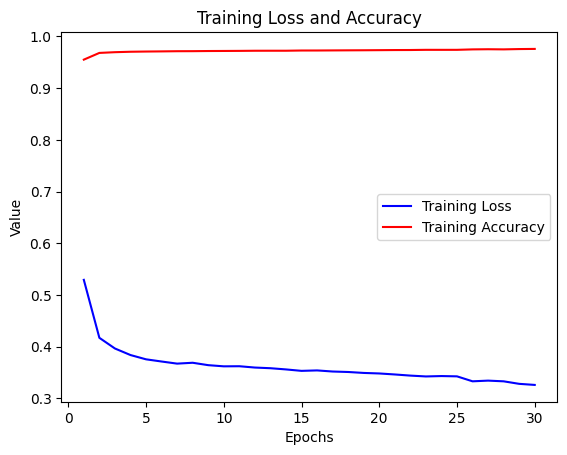

In [16]:
# Membuat model FCDenseNet dengan 4 kelas dan ukuran gambar 224x224
model = FCDenseNet(n_classes=4, input_height=224, input_width=224)


# Membuat VGG16 model dengan imagenet weights
VGG16_MODEL = VGG16(include_top=False, weights='imagenet')

# Melakukan Transfer learning VGG16 Model
for layer, vgg_layer in zip(model.layers, VGG16_MODEL.layers):
    if isinstance(layer, Conv2D) and isinstance(vgg_layer, Conv2D):
        layer.set_weights(vgg_layer.get_weights())

optimizer_type = 'Adam'
lr = 0.001

# Melakukan Compile Model dengan Optimizer Adam dan Learning Rate 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=sm.losses.categorical_focal_dice_loss,
              metrics=['accuracy'])

# Mendaftarkan kondisi early stopping di 5 epoch terakhir dengan pertimbangan nilai loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# Mengimplementasikan dan melatih mesin / model pada dataset
history = model.fit(train_images,
                    train_masks,
                    batch_size=4,
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping, checkpoint_cb])

# Plot Loss and Accuracy Graph
loss = history.history['loss']
acc = history.history['accuracy']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [17]:
# Save model
model.save(f'h5_models/model_seg_jantung_FCDenseNet.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Testing Model Menggunaan Dice Coefficient
import os
import numpy as np
import cv2
import glob
import tensorflow as tf
from keras.models import load_model
from keras.metrics import MeanIoU
import segmentation_models as sm

# Define function to calculate Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


# Define function to calculate IoU
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


# Load and preprocess test images and masks
def load_test_data(dataset_path, size_x=224, size_y=224):
    images = []
    masks = []
    class_ranges = [
        ([226, 226, 226], [255, 255, 255]),  # Class 1 (white)
        ([151, 151, 151], [225, 225, 225]),  # Class 2 (light gray)
        ([50, 50, 50], [150, 150, 150]),  # Class 3 (darker gray)
        ([0, 0, 0], [49, 49, 49])  # Class 4 (black)
    ]

    for subfolder_name in ['es_testing', 'ed_testing']:
        subfolder_path = os.path.join(dataset_path, "testing", "image", subfolder_name)
        for img_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (size_x, size_y))
            images.append(img)

    for subfolder_name in ['es_testing_gt', 'ed_testing_gt']:
        subfolder_path = os.path.join(dataset_path, "testing", "mask", subfolder_name)
        for mask_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            mask = cv2.resize(mask, (size_x, size_y))

            class_masks = []
            for (lower, upper) in class_ranges:
                mask_class = cv2.inRange(mask, np.array(lower), np.array(upper))
                mask_class = (mask_class / 255).astype(np.uint8)
                class_masks.append(mask_class)

            multiclass_mask = np.stack(class_masks, axis=-1)
            masks.append(multiclass_mask)

    return np.array(images), np.array(masks)


# Load test data
test_images, test_masks = load_test_data('/kaggle/input/dataset-cmri-jantung-2-0/Dataset-CMRI-Jantung')

print("Test Images: ", test_images.shape)
print("Test Masks: ", test_masks.shape)

# Ensure images and masks have the same length
if test_images.shape[0] != test_masks.shape[0]:
    print("Error: The number of test images and test masks do not match.")
    exit()

# Preprocess input
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
test_images = preprocess_input(test_images)

# Predict masks
pred_masks = model.predict(test_images)

# Initialize lists to store the metrics for each class
dice_scores = [[] for _ in range(4)]
iou_scores = [[] for _ in range(4)]

# Calculate Dice Coefficient and IoU for each test image
for i in range(len(test_images)):
    true_mask = test_masks[i]
    pred_mask = np.argmax(pred_masks[i], axis=-1)

    for j in range(4):
        true_class = (true_mask[:, :, j] == 1).astype(np.float32)
        pred_class = (pred_mask == j).astype(np.float32)

        dice = dice_coefficient(true_class, pred_class)
        iou = iou_score(true_class, pred_class)

        dice_scores[j].append(dice)
        iou_scores[j].append(iou)

# Calculate mean and std for Dice Coefficient and IoU for each class
dice_mean_std = [(np.mean(scores), np.std(scores)) for scores in dice_scores]
iou_mean_std = [(np.mean(scores), np.std(scores)) for scores in iou_scores]

# Print results
labels = ["RV", "Myo", "LV", "Background"]
for i, label in enumerate(labels):
    print(f"{label} Dice Coefficient: {dice_mean_std[i][0]}")
    print(f"{label} Dice Coefficient std: {dice_mean_std[i][1]}")
    print(f"{label} IoU: {iou_mean_std[i][0]}")
    print(f"{label} IoU std: {iou_mean_std[i][1]}")

Test Images:  (506, 224, 224, 3)
Test Masks:  (506, 224, 224, 4)
16/16 [==============================] - 97s 3s/step
RV Dice Coefficient: 0.7977759516565835
RV Dice Coefficient std: 0.2841640186405642
RV IoU: 0.7328700082322134
RV IoU std: 0.2968055360797165
Myo Dice Coefficient: 0.7515716753915108
Myo Dice Coefficient std: 0.22486355265376332
Myo IoU: 0.6427854059933845
Myo IoU std: 0.2300381698619386
LV Dice Coefficient: 0.6181802073754136
LV Dice Coefficient std: 0.3839443597772212
LV IoU: 0.5473481311952775
LV IoU std: 0.36303785480218265
Background Dice Coefficient: 0.9946387105563814
Background Dice Coefficient std: 0.006178687734675593
Background IoU: 0.9894086603468242
Background IoU std: 0.012051106170206837


506
506
1/1 [==============================] - 0s 25ms/step


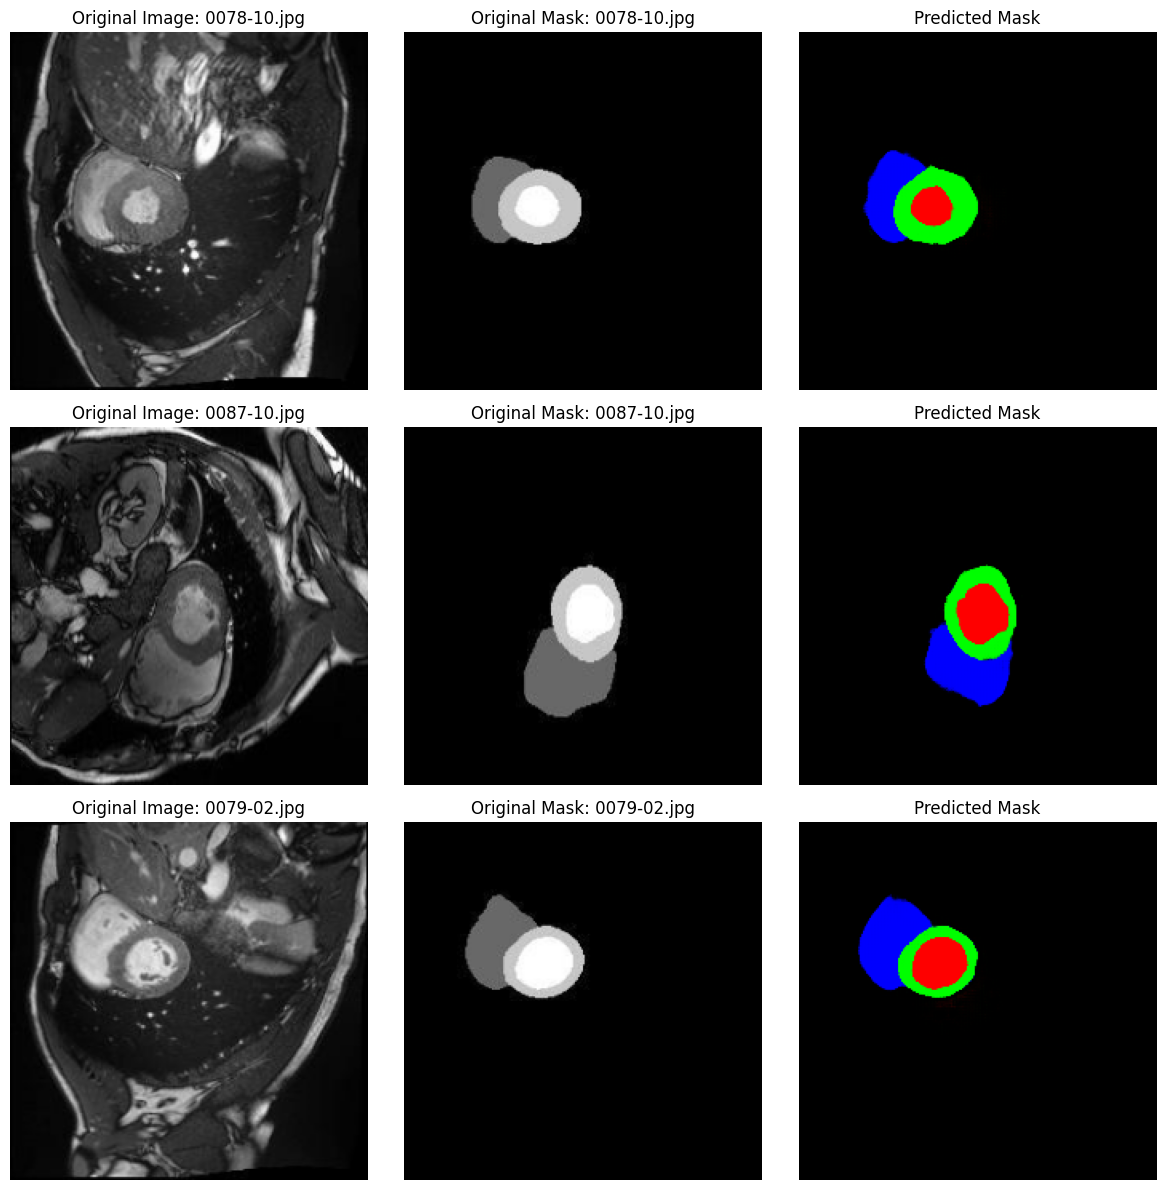

In [19]:
# Visualisasi Perbandingan Image Testing dan Image Hasil Prediction
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

SIZE_X = 224
SIZE_Y = 224

dataset_path = '/kaggle/input/dataset-cmri-jantung-2-0/Dataset-CMRI-Jantung'

# Get testing image paths
testing_img_path = []
for subfolder_name in ['es_testing', 'ed_testing']:
    subfolder_path = os.path.join(dataset_path, "testing", "image", subfolder_name)
    for img_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
        testing_img_path.append(img_path)

print(len(testing_img_path))

# Get testing mask paths
testing_mask_path = []
for subfolder_name in ['es_testing_gt', 'ed_testing_gt']:
    subfolder_path = os.path.join(dataset_path, "testing", "mask", subfolder_name)
    for mask_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
        testing_mask_path.append(mask_path)

print(len(testing_mask_path))

# List of filenames (without extensions) to select
desired_filenames = ['0079-02', '0078-10', '0087-10']  # Replace with actual filenames

# Filter the paths based on the desired filenames
selected_img_paths = [img_path for img_path in testing_img_path if os.path.basename(img_path).split('.')[0] in desired_filenames]
selected_mask_paths = [mask_path for mask_path in testing_mask_path if os.path.basename(mask_path).split('.')[0] in desired_filenames]

# Ensure we have pairs of image and mask paths
selected_pairs = list(zip(selected_img_paths, selected_mask_paths))

# Create a figure with 3 rows and 3 columns for plotting
plt.figure(figsize=(12, 12))

# Loop through each selected pair and plot the image, mask, and predicted mask
for idx, (img_path, mask_path) in enumerate(selected_pairs, start=1):
    # Read the image and mask
    test_img = cv2.imread(img_path)
    test_mask = cv2.imread(mask_path)

    # Resize the images to the desired size
    test_img = cv2.resize(test_img, (SIZE_X, SIZE_Y))
    test_mask = cv2.resize(test_mask, (SIZE_X, SIZE_Y))

    # Expand dimensions of the image for prediction
    test_img = np.expand_dims(test_img, axis=0)

    # Get the predicted mask
    prediction = model.predict(test_img)

    # Create a combined mask image with different colors for each mask
    combined_pmask = np.zeros((SIZE_X, SIZE_Y, 3))
    combined_pmask[:, :, 0] = prediction[0, :, :, 0]  # Red channel for mask 1
    combined_pmask[:, :, 1] = prediction[0, :, :, 1]  # Green channel for mask 2
    combined_pmask[:, :, 2] = prediction[0, :, :, 2]  # Blue channel for mask 3

    img_name = os.path.basename(img_path).split('.')[0]
    mask_name = os.path.basename(mask_path).split('.')[0]

    # Plot the image, mask, and predicted mask in each row
    plt.subplot(3, 3, (idx - 1) * 3 + 1)
    plt.imshow(test_img[0])
    plt.title(f'Original Image: {img_name}.jpg')
    plt.axis('off')

    plt.subplot(3, 3, (idx - 1) * 3 + 2)
    plt.imshow(test_mask)
    plt.title(f'Original Mask: {mask_name}.jpg')
    plt.axis('off')

    plt.subplot(3, 3, (idx - 1) * 3 + 3)
    plt.imshow(combined_pmask)
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()